In [1]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from pandas_datareader import data

%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

In [2]:


# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# Use site: http://optionsforum.net/topic/268/50-stocks-with-most-liquid-options
'''
tickers = ['ABT', 'ABBV', 'PNR', 'CL', 'HRL', 'CLX', 'LOW', 'PG', 'BCR', 'PEP', 'CTAS',
          'XOM', 'EMR', 'PPG', 'GWW', 'ADM', 'TGT', 'AFL', 'ED', 'MMM', 'SHW', 'CVX',
          'WBA', 'SPGI', 'JNJ', 'DOV', 'KO', 'SWK', 'CAH', 'MCD', 'APD', 'FRT', 'VFC',
          'KMB', 'WMT', 'BDX', 'GPC', 'ADP', 'LEG', 'TROW', 'ECL', 'CINF', 'MDT', 'MKC',
          'ITW', 'BEN', 'NUE', 'SYY', 'T', 'GD']
'''
tickers = pd.read_csv('nov20list.csv')
tickers = list(tickers['Ticker'])
#tickers = ['TSN','JD']
# Define which online source one should use
data_source = 'google'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2007-01-01'
end_date = '2017-11-07'

start = dt.datetime(2007, 1, 1)
end = dt.datetime.today()

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start, end)

# panel_data.minor_xs('SPY')

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between start_date and end_date
#all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
#close = close.reindex(all_weekdays)


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [3]:
# Function for calculating standard dev and price moves in terms of standard dev
# DF[[Adj Close]] Rolling Period --> DF[['Daily Vol','Daily Price Vol','Price Dev','Annual Vol']]
def price_devs(close_prices,roll_period,plot_window, hist_window,ticker):
    df = close_prices.copy()
    df.columns = ['prices']
    df['prices_delta'] = df.prices - df.prices.shift(1)
    df['log_returns'] = np.log(df.prices) - np.log(df.prices.shift(1))
    df['daily_vol'] = st.rolling_std(df.log_returns, roll_period, ddof = 1)
    df['daily_vol_dollar'] = df.daily_vol*df.prices
    df['price_dev'] = df.prices_delta/df.daily_vol_dollar.shift(1)
    df['annual_vol'] = df.daily_vol*np.sqrt(252)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    
    df['price_dev'].tail(plot_window).plot(kind = 'bar',ax=axes[0,0], rot=20)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.tail(plot_window).index)
    # Every ith ticklable shows the month and day
    i = int(plot_window/10)
    ticklabels[::i] = [item.strftime('%b %d %Y') for item in df.tail(plot_window).index[::i]]
    # Every jth ticklabel includes the year
    j = i
    ticklabels[::j] = [item.strftime('%b %d\n%Y') for item in df.tail(plot_window).index[::j]]
    #axes[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter(ticklabels))
    axes[0,0].set_xlabel('')
    axes[0,0].set_xticklabels(ticklabels)
    
    df.tail(hist_window).price_dev.hist(bins = 20,ax=axes[0,1])
    df.tail(hist_window)[df.price_dev < 0].price_dev.hist(bins = 10,ax=axes[1,0])
    df.tail(hist_window)[df.price_dev >= 0].price_dev.hist(bins = 10,ax=axes[1,1])
    
    axes[0,0].set_title('Period Price Deviations')
    axes[0,1].set_title('Distribution of Price Deviations')
    axes[1,0].set_title('Left-Side Distribution')
    axes[1,1].set_title('Right-Side Distribution')
    fig.suptitle(ticker,fontsize=20)
    print(df.tail(5))
    return df

In [4]:
def vol_summary(adj_c_df,rolling_period,lookback_window,hist_window,ticker):
    etf = price_devs(adj_c_df,rolling_period,lookback_window,hist_window,ticker)
    
    # Describing Deviation Data
    obs = hist_window

    #print(etf.price_dev.tail(obs).describe())#percentiles = list(np.arange(0.1,1,0.1))))
    print('---------------------')
    # Finding date of largest drop
    print('Date of largest drop')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmin())])
    print(etf.price_dev.tail(obs).idxmin())
    print('---------------------')
    # Finding date of largest spike
    print('Date of largest spike')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmax())])
    print(etf.price_dev.tail(obs).idxmax())
    print('---------------------')
    # Histogram Bins
    d = {'Std Bins':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[1][:-1],
        'Frequency':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[0]}
    df = pd.DataFrame(d,index = d['Std Bins'])[['Frequency']]
    #print(df)
    return df, etf

In [18]:
rolling_period = 4
lookback_window = 100
hist_window = 500
ticker = 'JD'
#summary, full_df = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2017-11-08   93.90          0.28     0.002986   0.006911          0.648988   
2017-11-09   94.38          0.48     0.005099   0.003854          0.363719   
2017-11-10   95.06          0.68     0.007179   0.002158          0.205138   
2017-11-13   93.69         -1.37    -0.014517   0.009951          0.932288   
2017-11-14   93.45         -0.24    -0.002565   0.009816          0.917341   

            price_dev  annual_vol  
Date                               
2017-11-08   0.330185    0.109716  
2017-11-09   0.739613    0.061177  
2017-11-10   1.869574    0.034257  
2017-11-13  -6.678425    0.157964  
2017-11-14  -0.257431    0.155830  
---------------------
Date of largest drop
-10.8270220601
2016-11-30 00:00:00
---------------------
Date of largest spike
7.68341368855
2017-08-24 00:00:00
---------------------


C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2017-11-08   78.09          0.46     0.005908   0.009478          0.740169   
2017-11-09   78.08         -0.01    -0.000128   0.005324          0.415723   
2017-11-10   77.49         -0.59    -0.007585   0.005780          0.447929   
2017-11-13   77.53          0.04     0.000516   0.005547          0.430054   
2017-11-14   79.23          1.70     0.021690   0.012593          0.997755   

            price_dev  annual_vol  
Date                               
2017-11-08   0.238283    0.150465  
2017-11-09  -0.013510    0.084521  
2017-11-10  -1.419215    0.091762  
2017-11-13   0.089300    0.088055  
2017-11-14   3.952994    0.199910  
---------------------
Date of largest drop
-6.43811111843
2017-07-20 00:00:00
---------------------
Date of largest spike
6.29581667836
2017-03-01 00:00:00
---------------------
            prices  pri

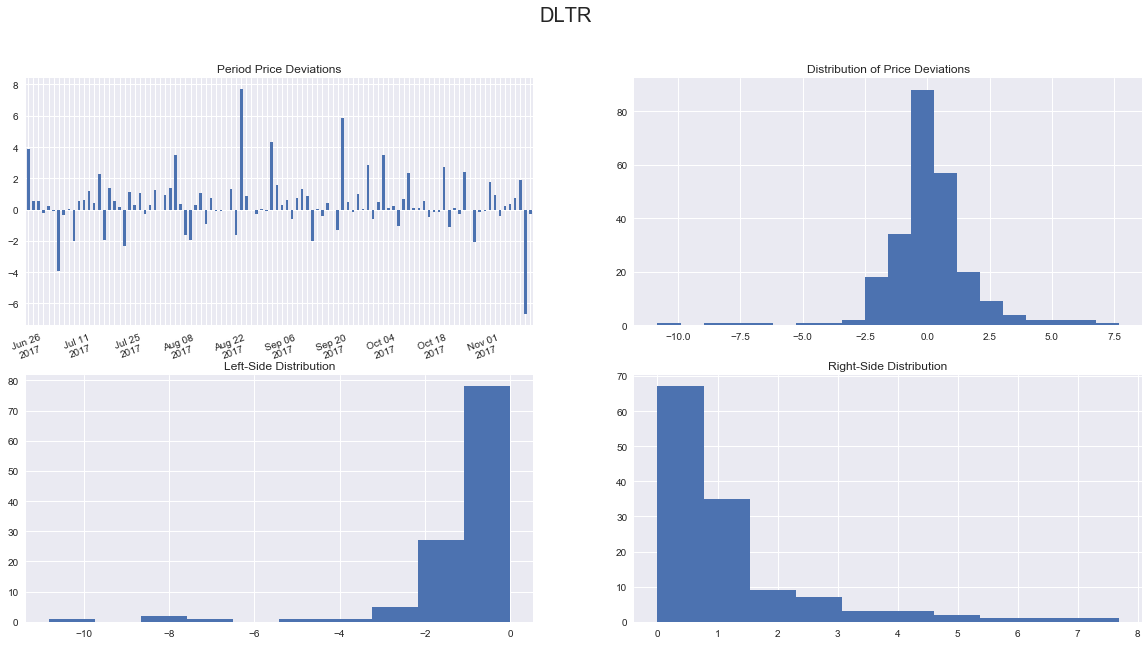

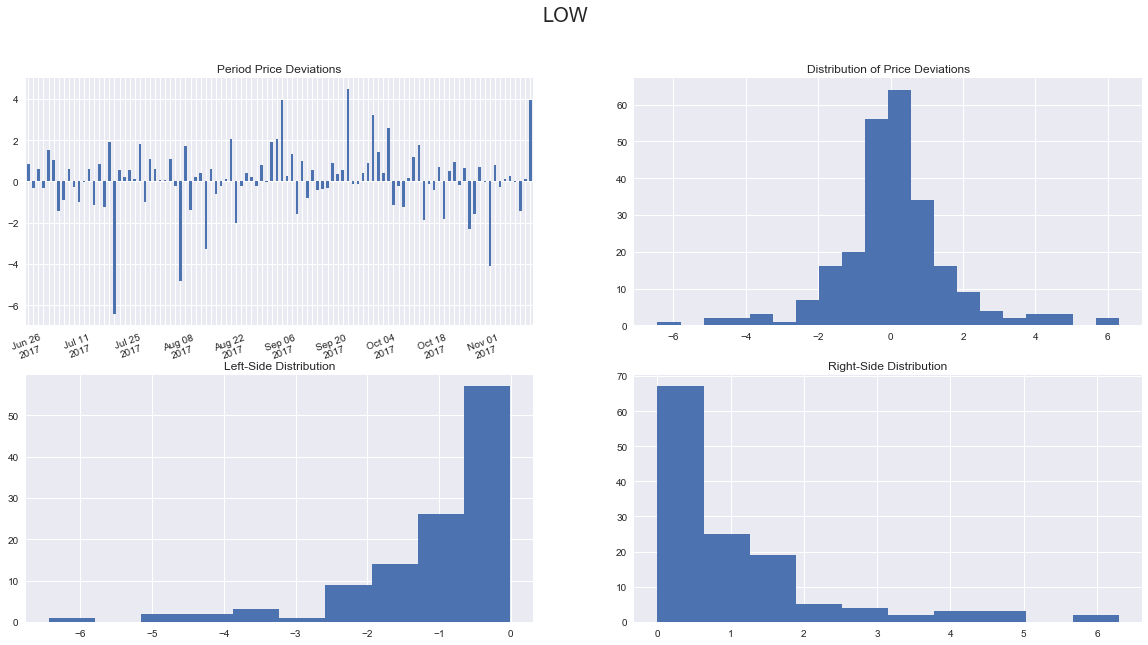

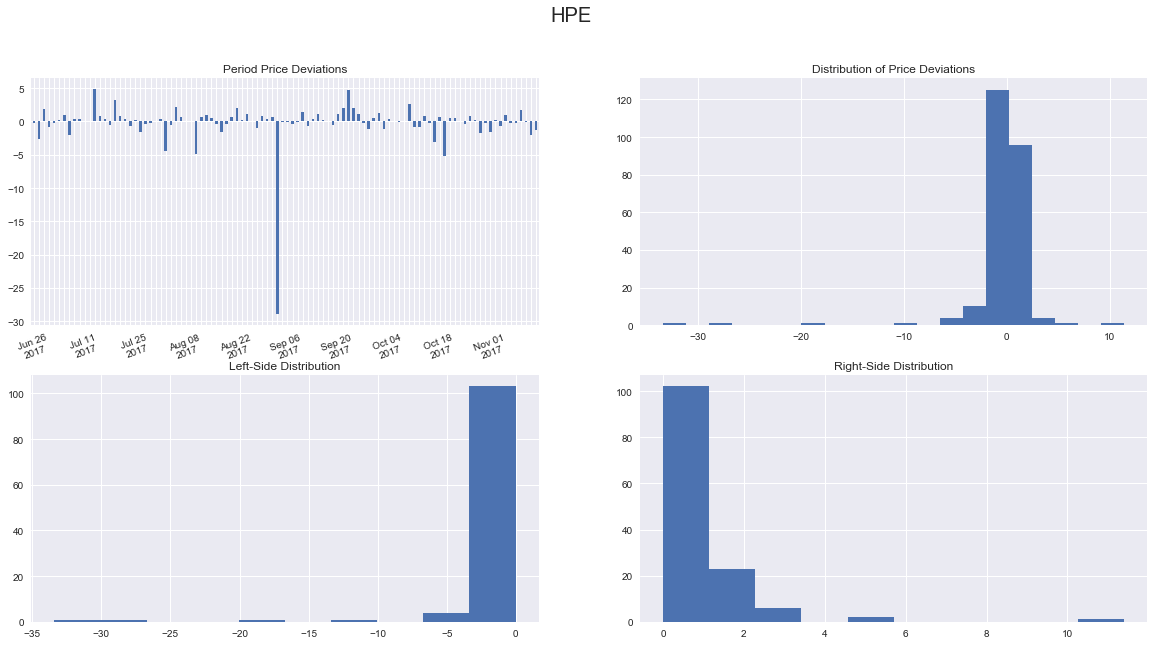

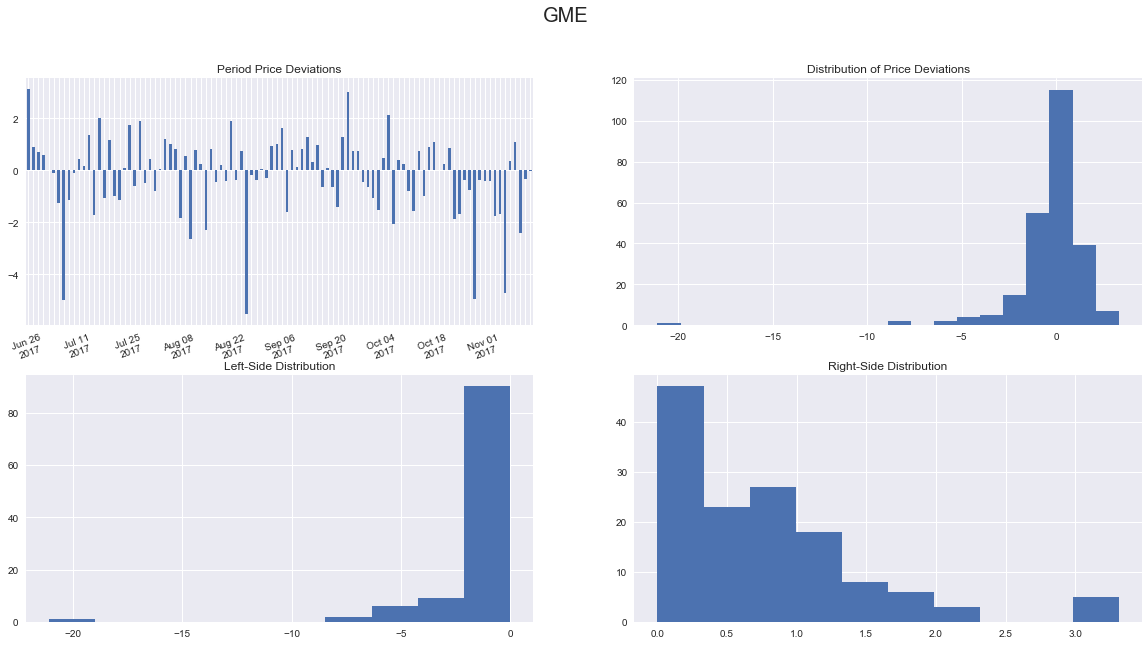

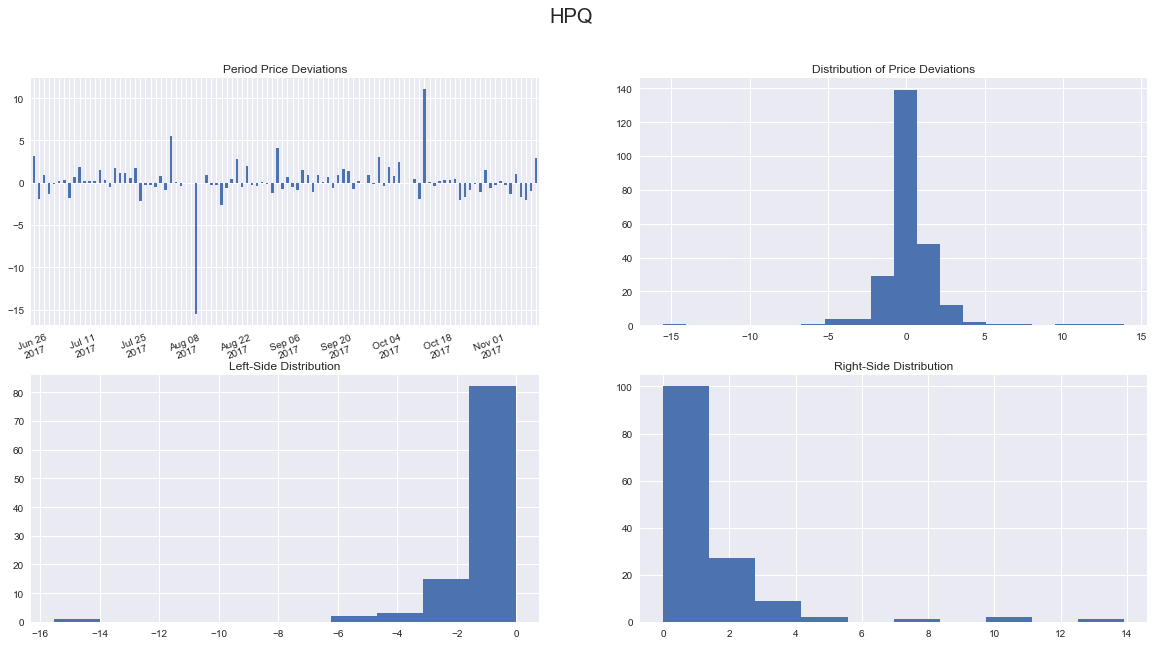

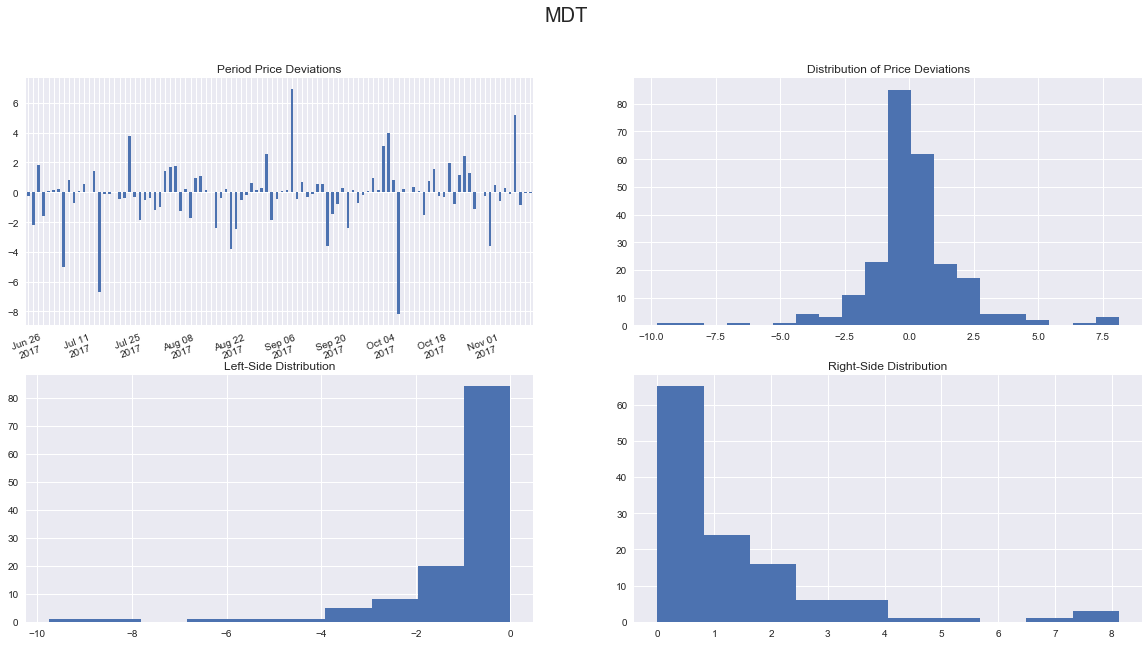

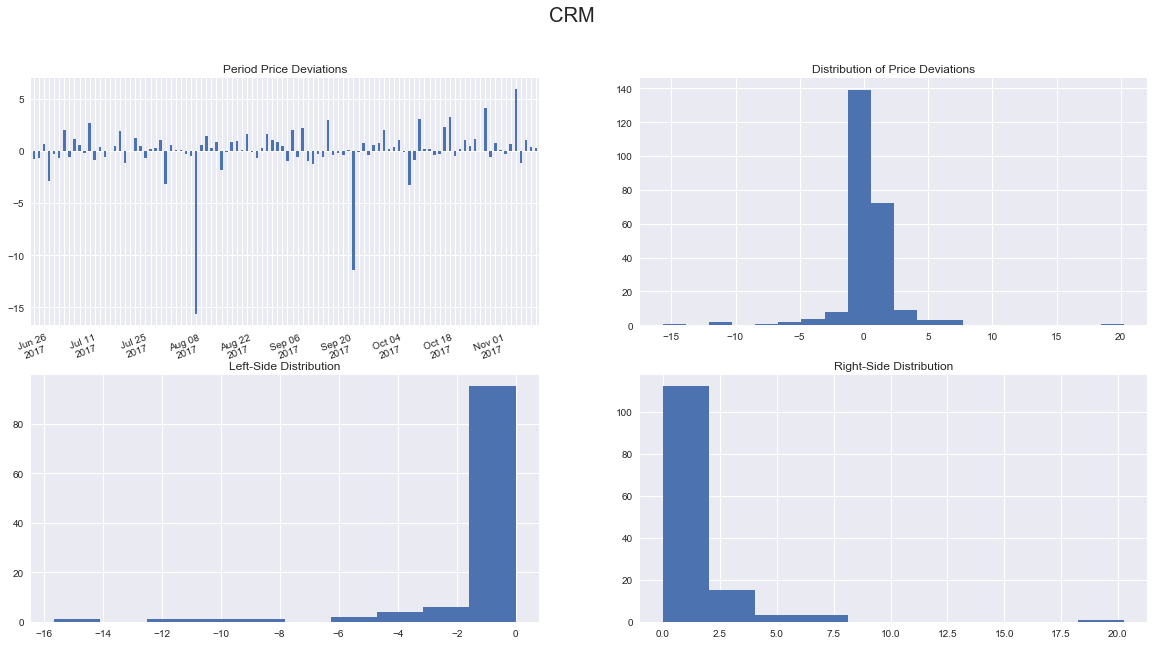

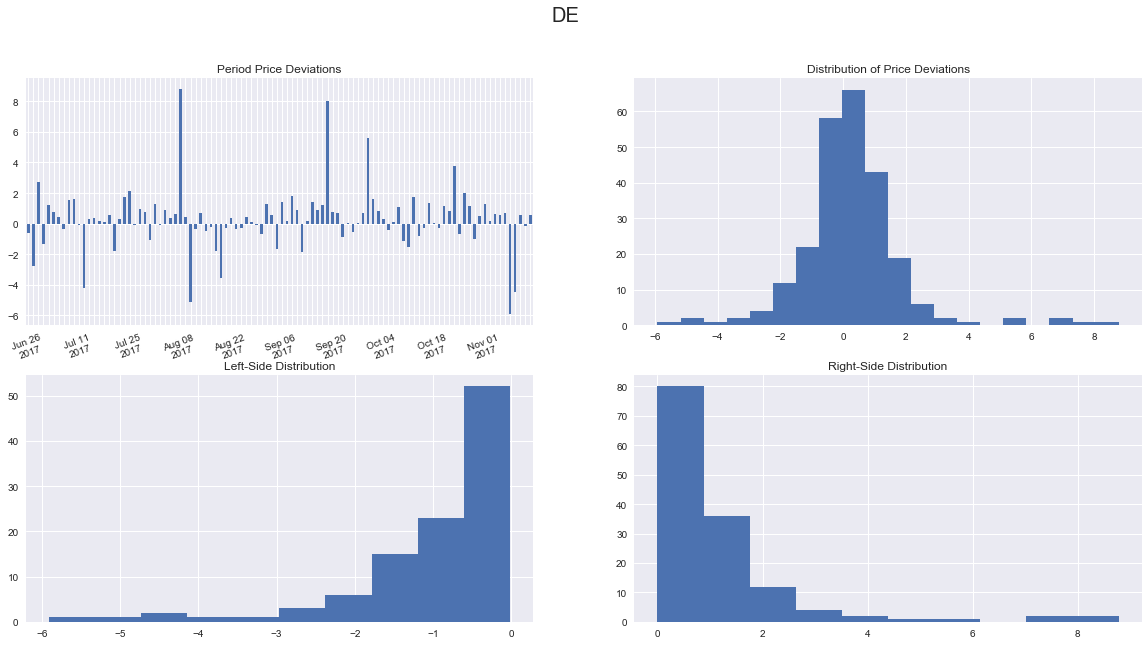

In [5]:
rolling_period = 4
lookback_window = 100
hist_window = 500
for ticker in tickers:
    stock = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

In [6]:
dic = {}
clse = []
tkers = []
for ticker in tickers:
    clse = clse + [close[[ticker]].iloc[-1][ticker]]
    tkers = tkers + [ticker]
    
dic['Close'] = clse
dic['Ticker'] = tkers
pd.DataFrame(dic)

,Close,Ticker
0,93.45,DLTR
1,79.23,LOW
2,13.27,HPE
3,16.19,GME
4,21.36,HPQ
5,79.16,MDT
6,106.23,CRM
7,132.88,DE


In [19]:
full_df['price_dev'].dropna().skew()

0.66342025885741696

In [20]:
full_df['price_dev'].dropna().describe()

count    245.000000
mean       0.108880
std        1.947956
min       -7.155920
25%       -0.675956
50%        0.107322
75%        0.700297
max       10.090276
Name: price_dev, dtype: float64

In [28]:
std_thresh = 4

down_nums = summary[summary.index <= -std_thresh].sum()
up_nums = summary[summary.index >= std_thresh].sum()

print("Threshold stdev: {0} \nNumber of deviations downward: {1} \nNumber of deviations upward: {2}".format(std_thresh,
                                                                                                           down_nums,
                                                                                                           up_nums))

Threshold stdev: 4 
Number of deviations downward: Frequency    7
dtype: int64 
Number of deviations upward: Frequency    10
dtype: int64


Frequency    10
dtype: int64